## Figure 3: In-depth characterization of BAL monocyte-like macrophages in various ILD subtypes

In [1]:
library(Seurat)          
library(ggplot2)       
library(dplyr)       
library(tidyr)             
library(ComplexHeatmap) 
library(slingshot)      
library(msigdbr)       
library(fgsea)
library(cowplot)        
library(scales)        
library(speckle)    
library(circlize)
library(broom)
library(purrr)
set.seed(1) 

options(repr.plot.width = 25, repr.plot.height = 15)
options(ggrepel.max.overlaps = Inf)


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.25.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effo

In [2]:
# Load Seurat objects
bal <- readRDS("BAL_FINAL.rds")
mdm <- readRDS("monomacs_only.rds")

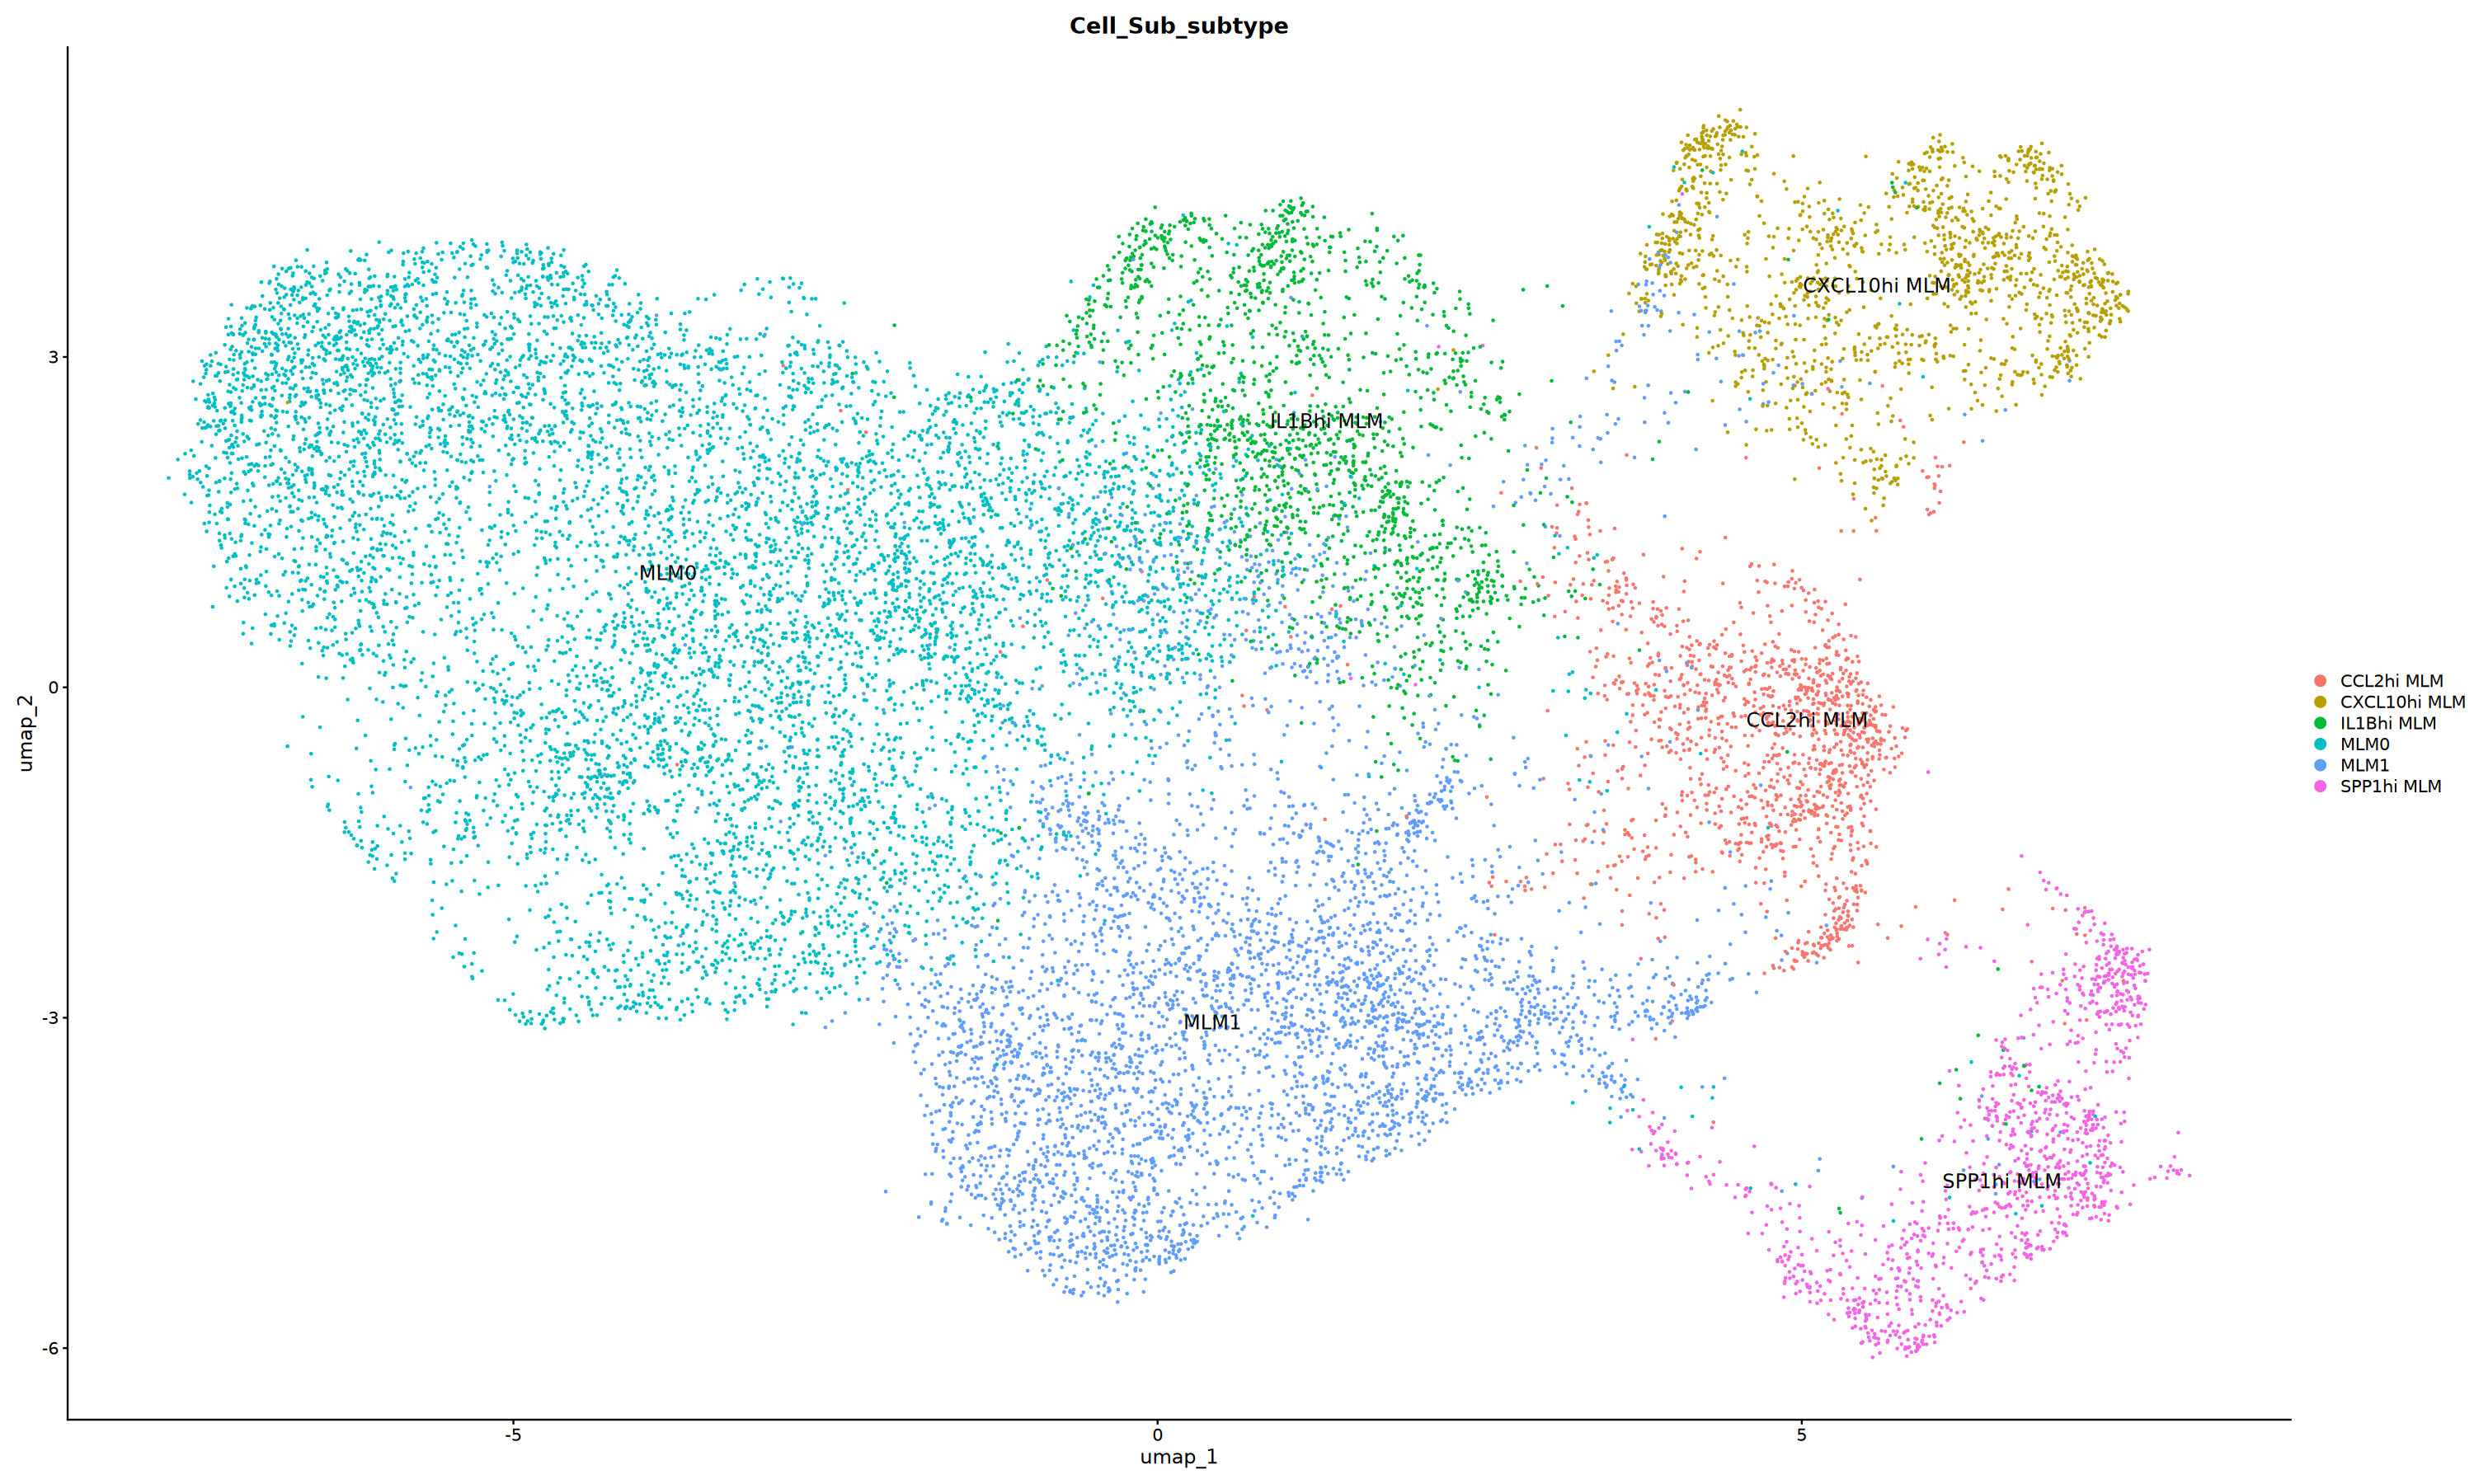

In [4]:
b <- DimPlot(mdm, reduction = "umap", group.by = c("Cell_Sub_subtype"))
LabelClusters(plot = b, id = "Cell_Sub_subtype", size = 5)

## Figure 3a: MSigDB Hallmark pathway analysis of MLM subclusters

In [ ]:
# as per FGSEA GESECA tutorial - https://bioconductor.org/packages/release/bioc/vignettes/fgsea/inst/doc/geseca-tutorial.html
# ensure mdm data is normalised via SCTransform - note we used 3000 genes instead of 10000 due to computational limitations
mdm <- SCTransform(mdm, verbose = FALSE, variable.features.n = 3000)

In [ ]:
# reverse PCA
mdm <- RunPCA(mdm, assay = "SCT", verbose = FALSE,
                rev.pca = TRUE, reduction.name = "pca.rev",
              reduction.key="PCR_", npcs = 50)
E <- mdm@reductions$pca.rev@feature.loadings

# select MSigDB Hallmark pathways for analysis - human
pathwaysDF <- msigdbr(species = "Homo sapiens", category = "H")
pathways <- split(pathwaysDF$gene_symbol, pathwaysDF$gs_name)

# run GESECA analysis and display top 10 significant pathways
set.seed(1)
gesecaRes <- geseca(pathways, E, minSize = 5, maxSize = 500, center = FALSE)
head(gesecaRes, 10)

# plot selected pathways of interest
keyPathways <- c("HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION", "HALLMARK_ANGIOGENESIS", "HALLMARK_INFLAMMATORY_RESPONSE", 
                 "HALLMARK_TNFA_SIGNALING_VIA_NFKB", "HALLMARK_HYPOXIA", "HALLMARK_APOPTOSIS", 
                 "HALLMARK_INTERFERON_ALPHA_RESPONSE", "HALLMARK_INTERFERON_GAMMA_RESPONSE", "HALLMARK_IL6_JAK_STAT3_SIGNALING")
    
ps <- plotCoregulationProfileReduction(pathways[keyPathways], mdm,
                                       reduction="umap")
options(repr.plot.width = 20, repr.plot.height = 16)
cowplot::plot_grid(plotlist=ps[1:9], ncol=3)

## Figure 3b: Trajectory analysis of MLM subclusters demonstrating two differential trajectories.
Senescence scoring via SenMayo gene set analysis confirming trajectory directionality. 
Genes upregulated along each trajectory with progressing pseudotime portrayed via heatmaps. 

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”


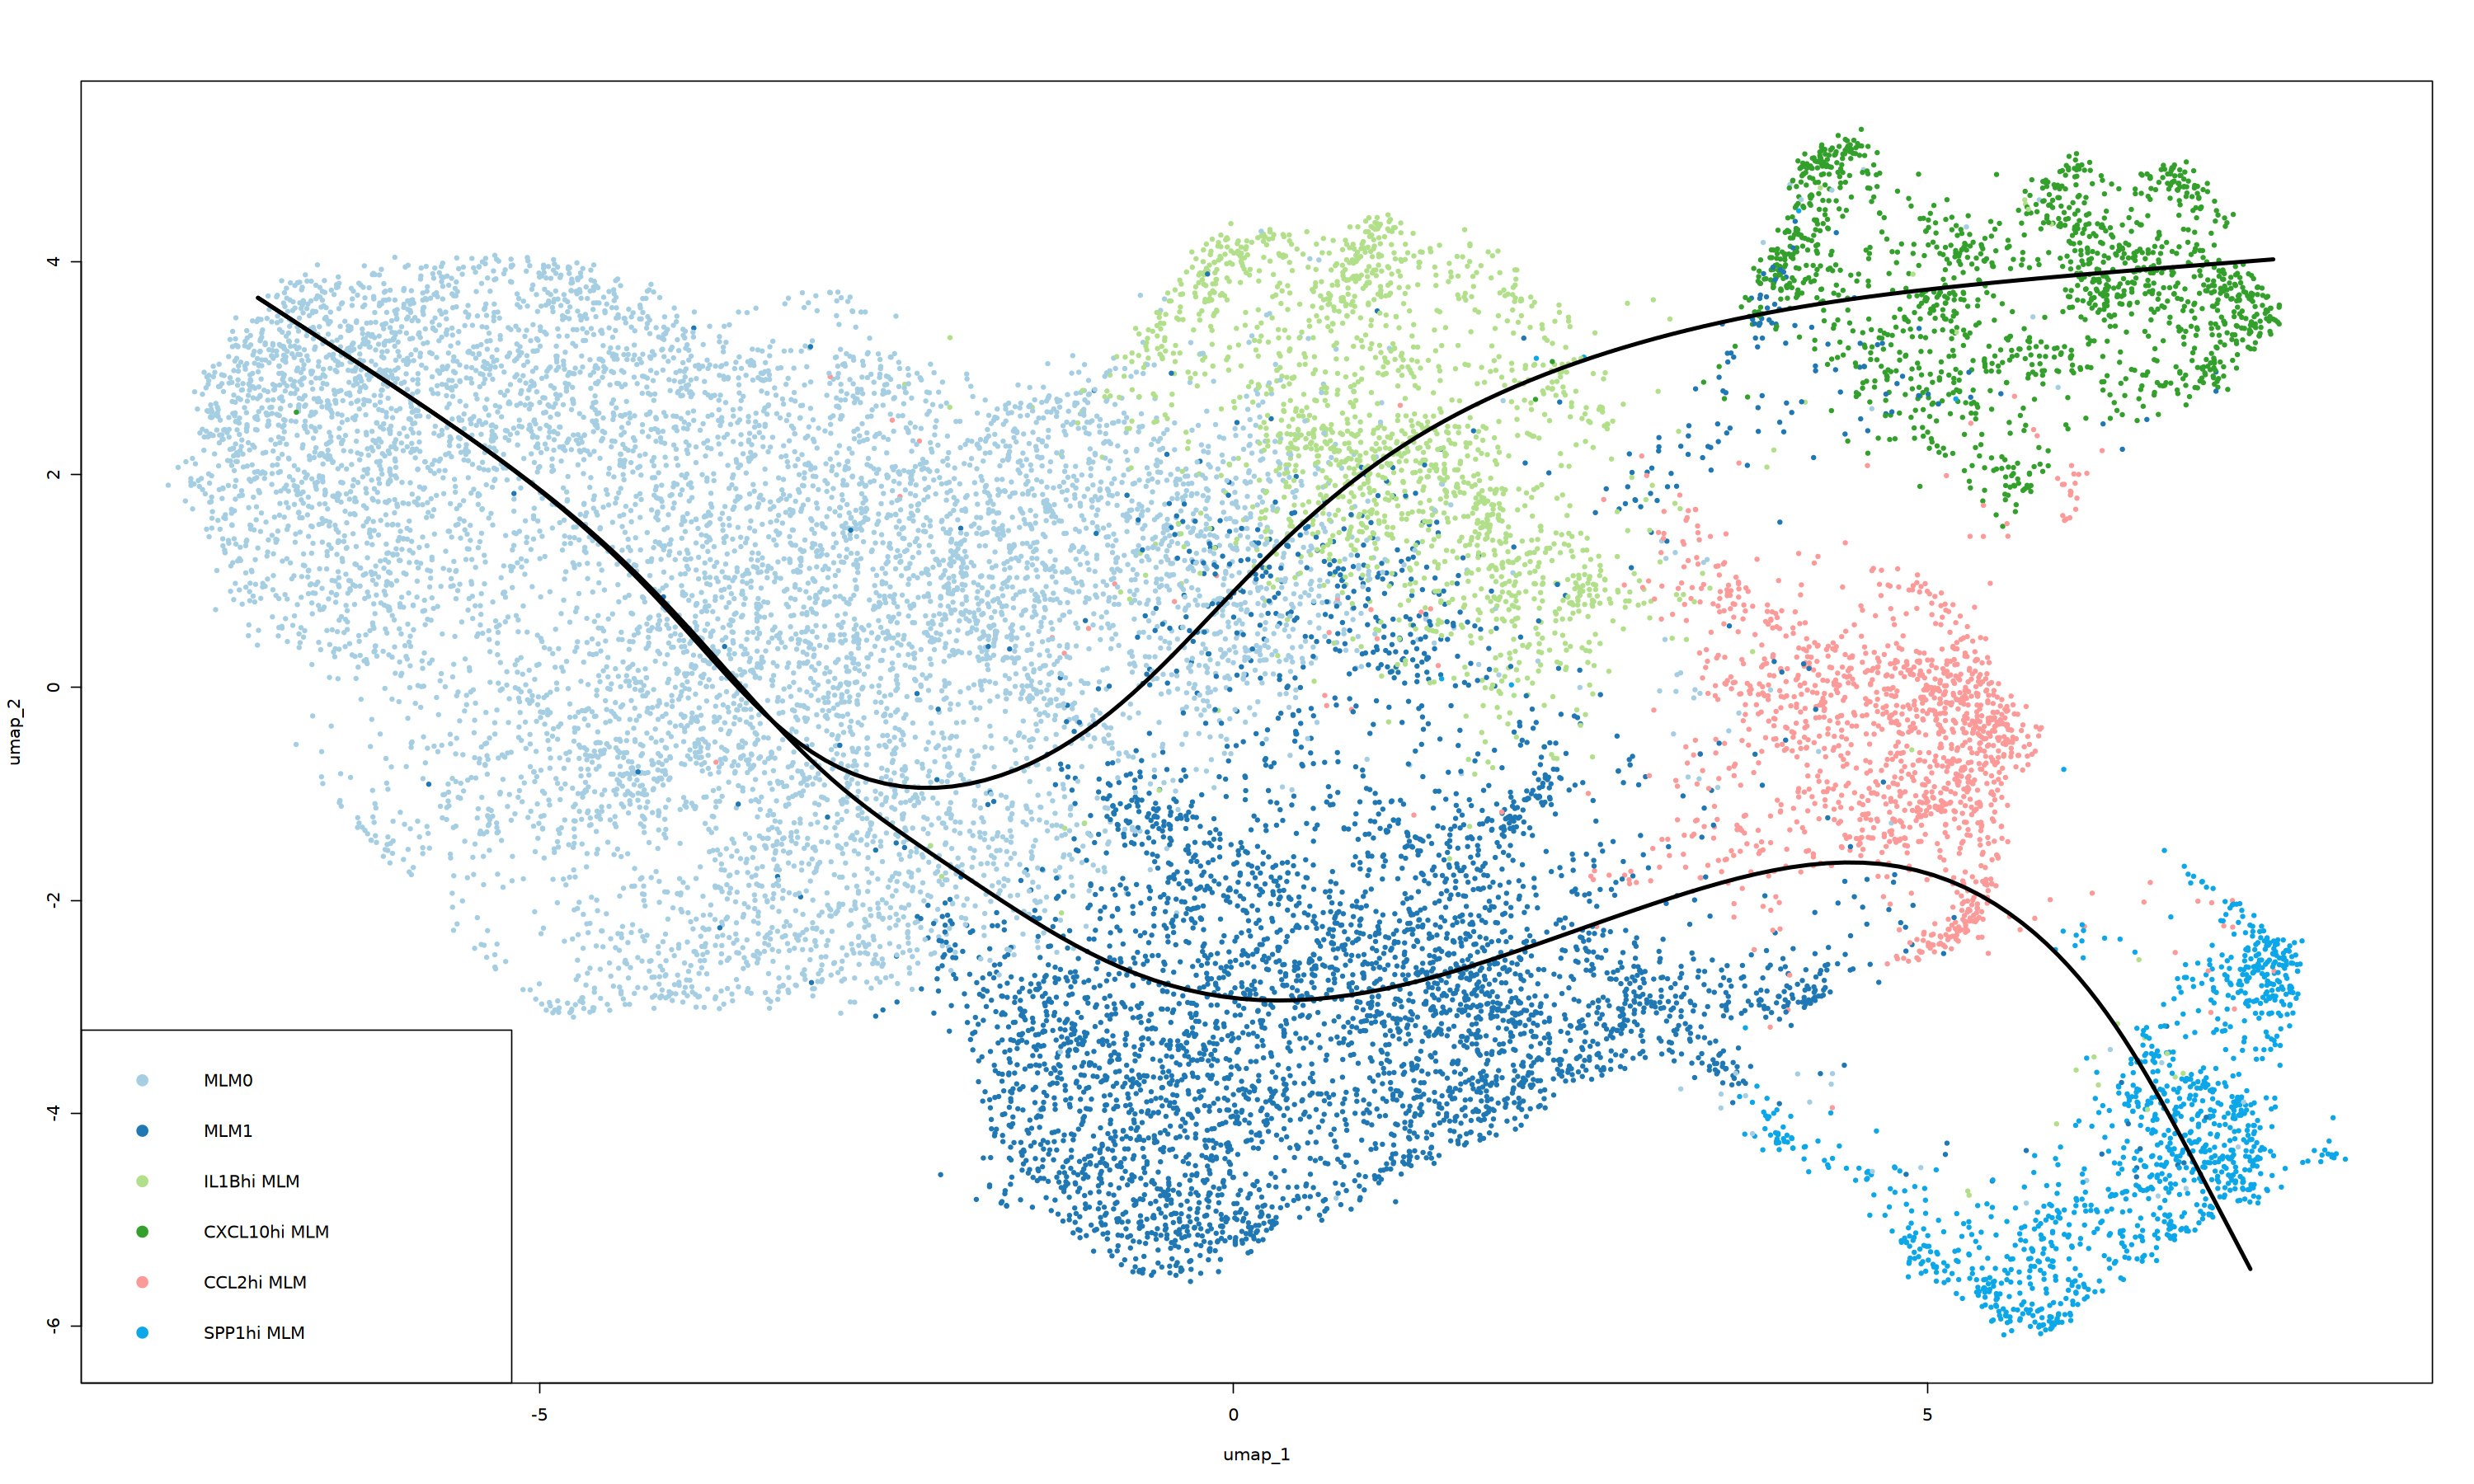

In [5]:
# as per slingshot vignette 

# Find variable features for dimensionality reduction
# This identifies the most informative genes to use in downstream analysis
mdm <- FindVariableFeatures(mdm, nfeatures = 10000)

# Extract the UMAP coordinates for each cell
dimred <- mdm@reductions$umap@cell.embeddings

# Get the cell type classifications for each cell
clustering <- mdm$Cell_Sub_subtype

# Extract count data for the variable features
# The raw counts for the most informative genes are used in trajectory calculations
counts <- as.matrix(mdm@assays$RNA$counts[mdm@assays$SCT@var.features, ])

set.seed(1)

# Identify lineage trajectories using Slingshot
# Specifying "MLM0" as the starting cluster, as it represents the initial monocyte-like state
lineages <- getLineages(data = dimred, clusterLabels = clustering, start.clus = "MLM0")

pal <- c(
    "MLM0" = "#A6CEE3",        # Light blue - Monocyte-like macrophages type 0
    "MLM1" = "#1F78B4",         # Dark blue - Monocyte-like macrophages type 1
    "IL1Bhi MLM" = "#B2DF8A",   # Light green - Inflammatory IL1B-high MLMs
    "CXCL10hi MLM" = "#33A02C", # Dark green - Interferon-responsive CXCL10-high MLMs
    "CCL2hi MLM" = "#FB9A99",   # Pink - Chemokine-producing CCL2-high MLMs
    "SPP1hi MLM" = "#0CA7E8"    # Bright blue - Tissue-remodeling SPP1-high MLMs
)

# Convert lineages to smooth curves
crv1 <- getCurves(lineages)

# Visualize the trajectory analysis results
# Plots cells in UMAP space colored by subtype, with trajectory paths overlaid
plot(dimred[, 1:2], col = pal[clustering], cex = 0.6, pch = 16)

# Add a legend identifying each macrophage subtype
legend("bottomleft", legend = names(pal), col = pal, pch = 20, cex = 1, pt.cex = 2, text.width = 2)

# Draw the trajectory paths as black lines connecting the macrophage subtypes
# These represent the inferred developmental progression between subtypes
lines(SlingshotDataSet(crv1), lwd = 3, col = "black")

Warning message:
“The following features are not present in the object: CCL3L1, CST4, IGFBP1, INHA, not searching for symbol synonyms”
Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


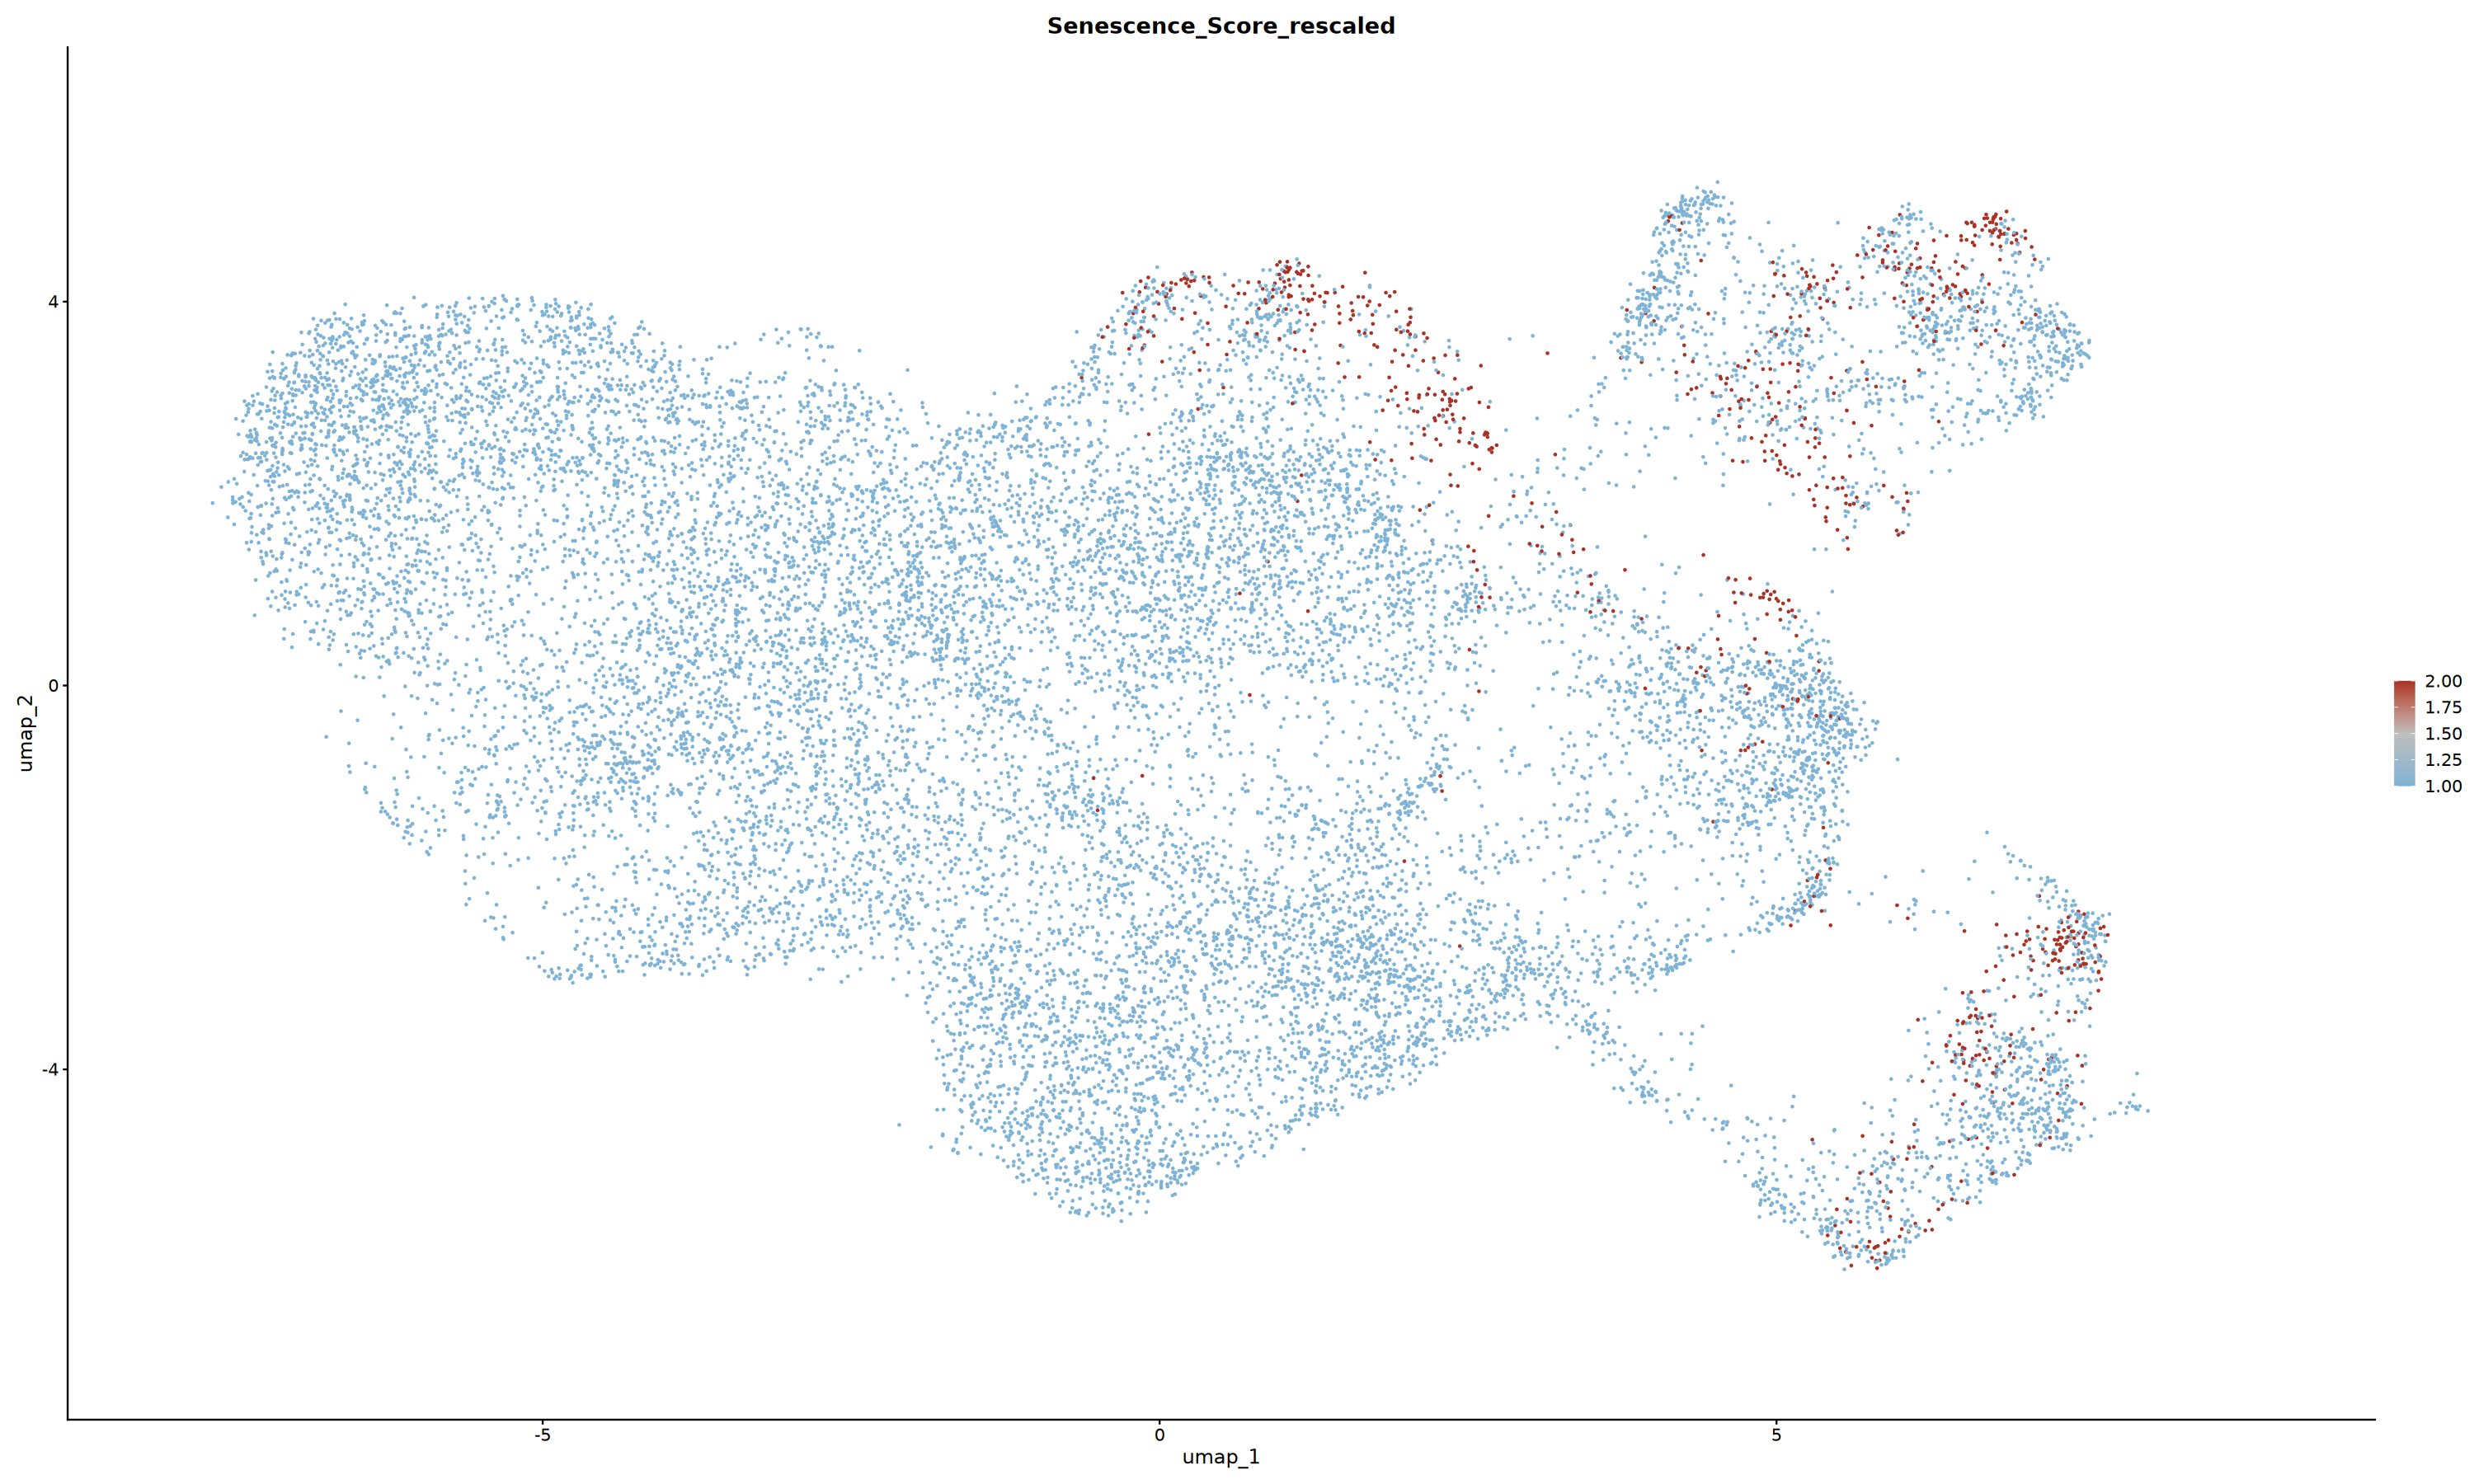

In [6]:
# plot senescence scoring on mlms - using SenMayo gene set and module scoring
senmayo <- c("ACVR1B", "ANG", "ANGPT1", "ANGPTL4", "AREG", "AXL", "BEX3", "BMP2", "BMP6", "C3", "CCL1", "CCL13", "CCL16", "CCL2", "CCL20", "CCL24", "CCL26", "CCL3", "CCL3L1", "CCL4", "CCL5", "CCL7", "CCL8", "CD55", "CD9", "CSF1", "CSF2", "CSF2RB", "CST4", "CTNNB1", "CTSB", "CXCL1", "CXCL10", "CXCL12", "CXCL16", "CXCL2", "CXCL3", "CXCL8", "CXCR2", "DKK1", "EDN1", "EGF", "EGFR", "EREG", "ESM1", "ETS2", "FAS", "FGF1", "FGF2", "FGF7", "GDF15", "GEM", "GMFG", "HGF", "HMGB1", "ICAM1", "ICAM3", "IGF1", "IGFBP1", "IGFBP2", "IGFBP3", "IGFBP4", "IGFBP5", "IGFBP6", "IGFBP7", "IL10", "IL13", "IL15", "IL18", "IL1A", "IL1B", "IL2", "IL32", "IL6", "IL6ST", "IL7", "INHA", "IQGAP2", "ITGA2", "ITPKA", "JUN", "KITLG", "LCP1", "MIF", "MMP1", "MMP10", "MMP12", "MMP13", "MMP14", "MMP2", "MMP3", "MMP9", "NAP1L4", "NRG1", "PAPPA", "PECAM1", "PGF", "PIGF", "PLAT", "PLAU", "PLAUR", "PTBP1", "PTGER2", "PTGES", "RPS6KA5", "SCAMP4", "SELPLG", "SEMA3F", "SERPINB4", "SERPINE1", "SERPINE2", "SPP1", "SPX", "TIMP2", "TNF", "TNFRSF10C", "TNFRSF11B", "TNFRSF1A", "TNFRSF1B", "TUBGCP2", "VEGFA", "VEGFC", "VGF", "WNT16", "WNT2")
mdm <- AddModuleScore(mdm, features = list(senmayo), name = "Senescence_Score")

# rescale module score for easy plotting and visualisation
mdm$Senescence_Score_rescaled <- rescale(mdm$Senescence_Score1, to = c(0, 5))
FeaturePlot(mdm, features = "Senescence_Score_rescaled", cols = c("#7fb3d5", "grey", "#a93226"))

In [7]:
# Generate heatmaps for genes upregulated along each trajectory
# Select top 2000 variable genes
top_var_genes <- head(mdm@assays$SCT@var.features, 2000)

# Extract counts for these genes
var_counts <- counts[top_var_genes, ]

# Run fitGAM
GAM_full <- tradeSeq::fitGAM(counts = var_counts,
                            sds = crv1,
                            nknots = 3,
                            verbose = TRUE,
                            parallel = FALSE)

# Test for trajectory association
AT_full <- tradeSeq::associationTest(GAM_full)

# Get significant genes
sig_genes <- rownames(AT_full)[AT_full$pvalue < 0.05]

In [16]:
# Create heatmap:

create_trajectory_heatmap <- function(pseudotime, counts_data, genes, n_bins=50, n_top_genes=30) {
    # Ensure genes exist in counts_data
    valid_genes <- intersect(genes, rownames(counts_data))
    
    # Filter out ENSG genes
    valid_genes <- valid_genes[!grepl("^ENSG", valid_genes)]
    print(paste0("Number of valid genes for heatmap (excluding ENSG): ", length(valid_genes)))
    
    if(length(valid_genes) == 0) {
        stop("No valid genes found for heatmap")
    }
    
    # Get valid cells for this trajectory
    valid_cells <- !is.na(pseudotime)
    pt_clean <- pseudotime[valid_cells]
    
    # Get expression data
    sig_counts <- counts_data[valid_genes, valid_cells]
    log_counts <- log1p(sig_counts)
    scaled_counts <- t(scale(t(log_counts)))
    
    # Create bins
    bin_breaks <- seq(min(pt_clean), max(pt_clean), length.out = n_bins + 1)
    pt_bins <- cut(pt_clean, breaks = bin_breaks, labels = FALSE)
    
    # Calculate binned expression
    binned_expression <- matrix(0, nrow = nrow(scaled_counts), ncol = n_bins)
    rownames(binned_expression) <- rownames(scaled_counts)
    
    for(i in 1:n_bins) {
        bin_cells <- which(pt_bins == i)
        if(length(bin_cells) > 0) {
            binned_expression[,i] <- rowMeans(scaled_counts[, bin_cells, drop = FALSE])
        }
    }
    
    # Calculate correlation with pseudotime for each gene
    gene_correlations <- apply(binned_expression, 1, function(x) {
        cor(x, 1:n_bins, method = "spearman")
    })
    
    # Select top positively correlated genes (increase over time)
    n_each <- floor(n_top_genes / 2)
    top_pos_genes <- names(sort(gene_correlations, decreasing = TRUE)[1:n_each])
    
    # Select top negatively correlated genes (decrease over time)
    top_neg_genes <- names(sort(gene_correlations, decreasing = FALSE)[1:n_each])
    
    # Combine with POSITIVE genes FIRST (will be at top)
    selected_genes <- c(top_pos_genes, top_neg_genes)
    final_expression <- binned_expression[selected_genes, ]
    
    # Order genes by their peak expression time (DESCENDING for bottom-left to top-right)
    peak_times <- apply(final_expression, 1, which.max)
    gene_order <- order(peak_times, decreasing = TRUE)
    final_expression <- final_expression[gene_order, ]
    
    # Cap extreme values
    final_expression[final_expression > 2.5] <- 2.5
    final_expression[final_expression < -2.5] <- -2.5
    
    return(final_expression)
}

[1] "Number of significant genes in counts matrix: 1742"
[1] "Number of valid genes for heatmap (excluding ENSG and LINC): 1625"
[1] "Selected genes:"
 [1] "C15orf48" "IL4I1"    "LILRB4"   "LGALS1"   "SPP1"     "MTSS1"   
 [7] "CCL3"     "SLC39A8"  "FAM20A"   "EMP1"     "CCL13"    "MMP7"    
[13] "CRABP2"   "CHI3L1"   "CCL2"     "MMP9"     "CCL22"    "GPC4"    
[19] "TYMS"     "ZNF385D"  "STAC"     "WDR49"    "MIR99AHG" "RPS6KA5" 
[25] "PCED1B"   "SVIL"     "SERPINI2" "FAM117B"  "LSAMP"    "MEGF9"   
[1] "Number of valid genes for heatmap (excluding ENSG and LINC): 1625"
[1] "Selected genes:"
 [1] "TNFSF10"    "HLA-B"      "SOCS1"      "HLA-DPA1"   "HLA-DPB1"  
 [6] "CALHM6"     "SAT1"       "CD63"       "HLA-DQA2"   "IL4I1"     
[11] "CXCL10"     "CXCL9"      "GBP5"       "GBP1"       "SLAMF7"    
[16] "VAMP5"      "SOD2"       "GBP4"       "CXCL11"     "SERPING1"  
[21] "CCL24"      "STAC"       "PTPN13"     "SYTL1"      "SNED1"     
[26] "PPARG"      "CALCRL-AS1" "TTTY14"     "FRY" 

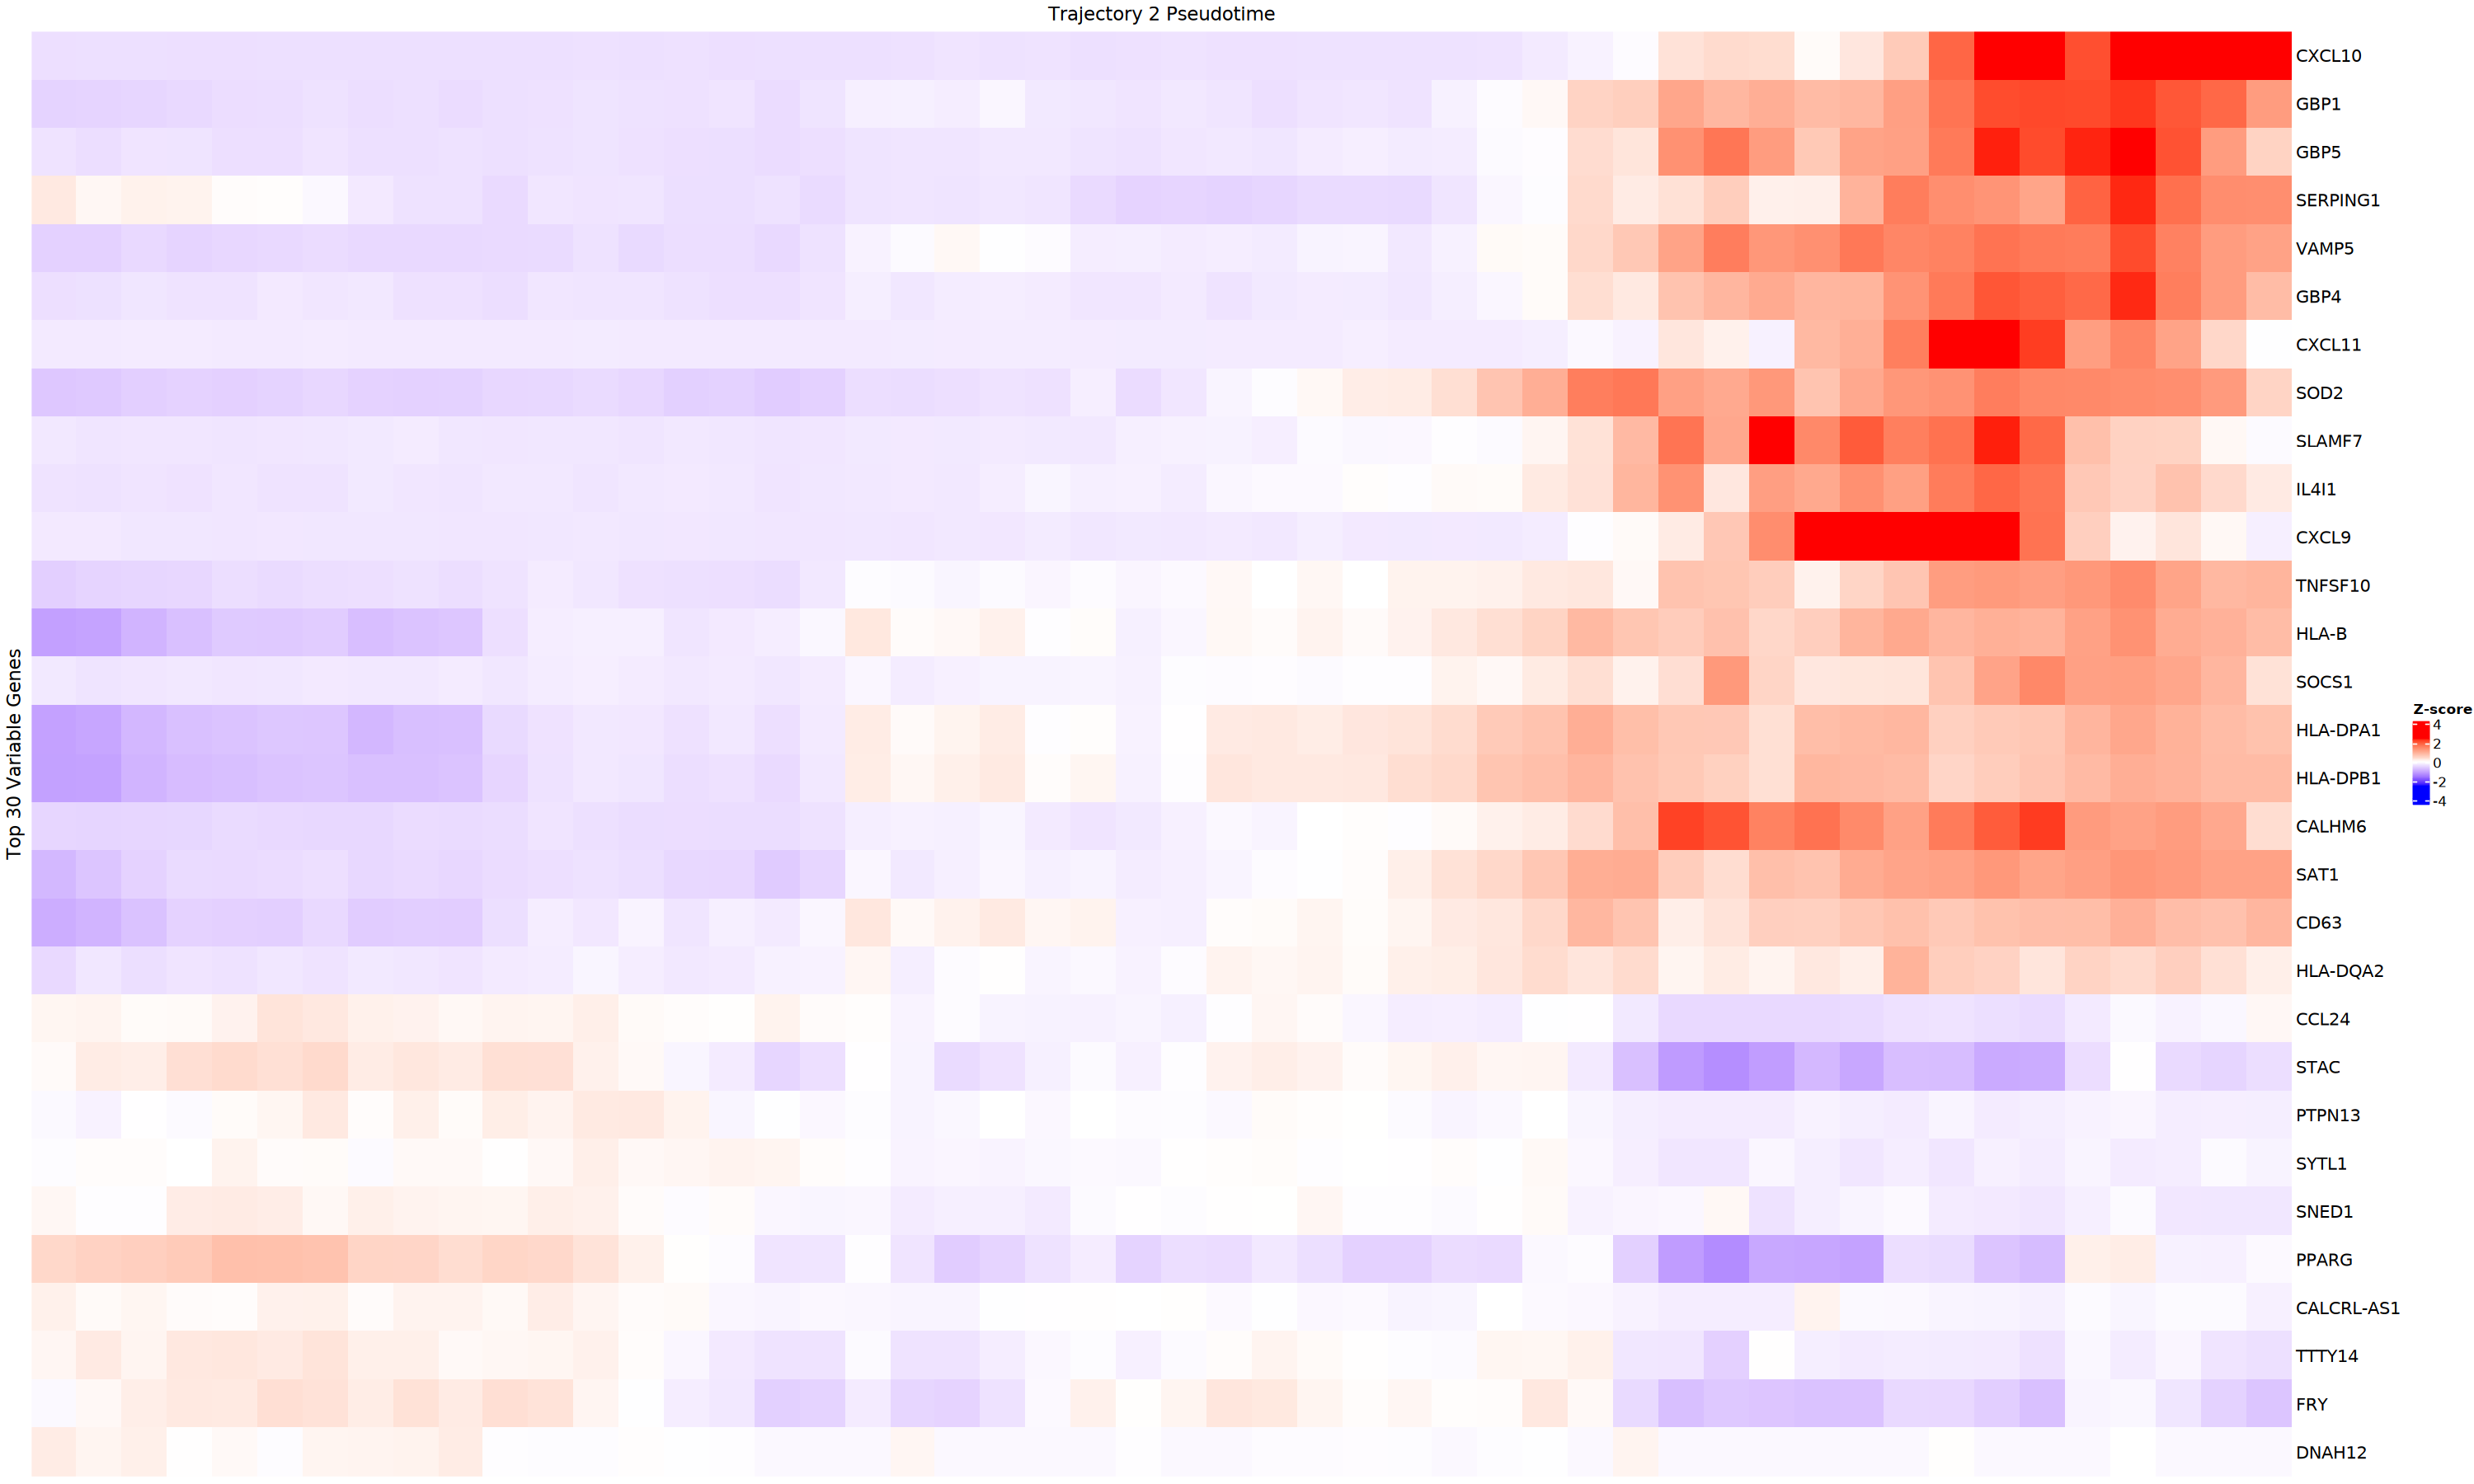

In [11]:
sig_genes_in_counts <- intersect(sig_genes, rownames(counts))
print(paste0("Number of significant genes in counts matrix: ", length(sig_genes_in_counts)))

# get pseudotime values for both trajectories from previous curves object
pt1 <- slingPseudotime(crv1)[,1]
pt2 <- slingPseudotime(crv1)[,2]

# Heatmap with 10 positively correlated with pseudotime + 10 high variance + 10 negatively correlated = 30 genes
expr1 <- create_trajectory_heatmap(pt1, counts, sig_genes_in_counts, 
                                   n_pos_corr=10, n_neg_corr=10, n_high_var=10)
custom_order <- c("MMP7", "CRABP2", "CCL22", "CHI3L1", "MMP9", "GPC4", "ZNF385D", 
                  "SPP1", "CCL3", "EMP1", "FAM20A", "SLC39A8", "MTSS1", "TYMS", "CCL2", 
                  "CCL13", "LGALS1", "C15orf48", "IL4I1", "LILRB4", 
                  "MEGF9", "STAC", "WDR49", "MIR99AHG", "RPS6KA5", "PCED1B", 
                  "SVIL", "SERPINI2", "FAM117B", "LSAMP")
expr1_ordered <- expr1[custom_order, ]


expr2 <- create_trajectory_heatmap(pt2, counts, sig_genes_in_counts, 
                                   n_pos_corr=10, n_neg_corr=10, n_high_var=10)
custom_order2 <- c("CXCL10", "GBP1", "GBP5", "SERPING1", "VAMP5", "GBP4", "CXCL11", "SOD2", "SLAMF7", "IL4I1", "CXCL9", "TNFSF10", "HLA-B", "SOCS1", "HLA-DPA1", "HLA-DPB1", "CALHM6", "SAT1", "CD63", "HLA-DQA2", "CCL24", "STAC", "PTPN13", "SYTL1", "SNED1", "PPARG", "CALCRL-AS1", "TTTY14", "FRY", "DNAH12")
expr2_ordered <- expr2[custom_order2, ]

# heatmap for trajectory 1 with specified order
ht1 <- Heatmap(expr1_ordered,
        name = "Z-score",
        cluster_rows = FALSE,  
        cluster_columns = FALSE,
        show_column_names = FALSE,
        show_row_names = TRUE,
        col = colorRamp2(c(-2.5, 0, 2.5), 
                        c("blue", "white", "red")),
        column_title = "Trajectory 1 Pseudotime",
        row_title = "Top 30 Variable Genes",
        use_raster = TRUE)

# heatmap for trajectory 2 with specified order
ht2 <- Heatmap(expr2_ordered,
        name = "Z-score",
        cluster_rows = FALSE,  
        cluster_columns = FALSE,
        show_column_names = FALSE,
        show_row_names = TRUE,
        col = colorRamp2(c(-2.5, 0, 2.5), 
                        c("blue", "white", "red")),
        column_title = "Trajectory 2 Pseudotime",
        row_title = "Top 30 Variable Genes",
        use_raster = TRUE)

# NOTE THAT FOR PUBLICATION PURPOSES, the naming for Trajectory 1 and Trajectory 2 have been switched
print("Trajectory 1 Heatmap:")
draw(ht2)

[1] "Trajectory 2 Heatmap:"


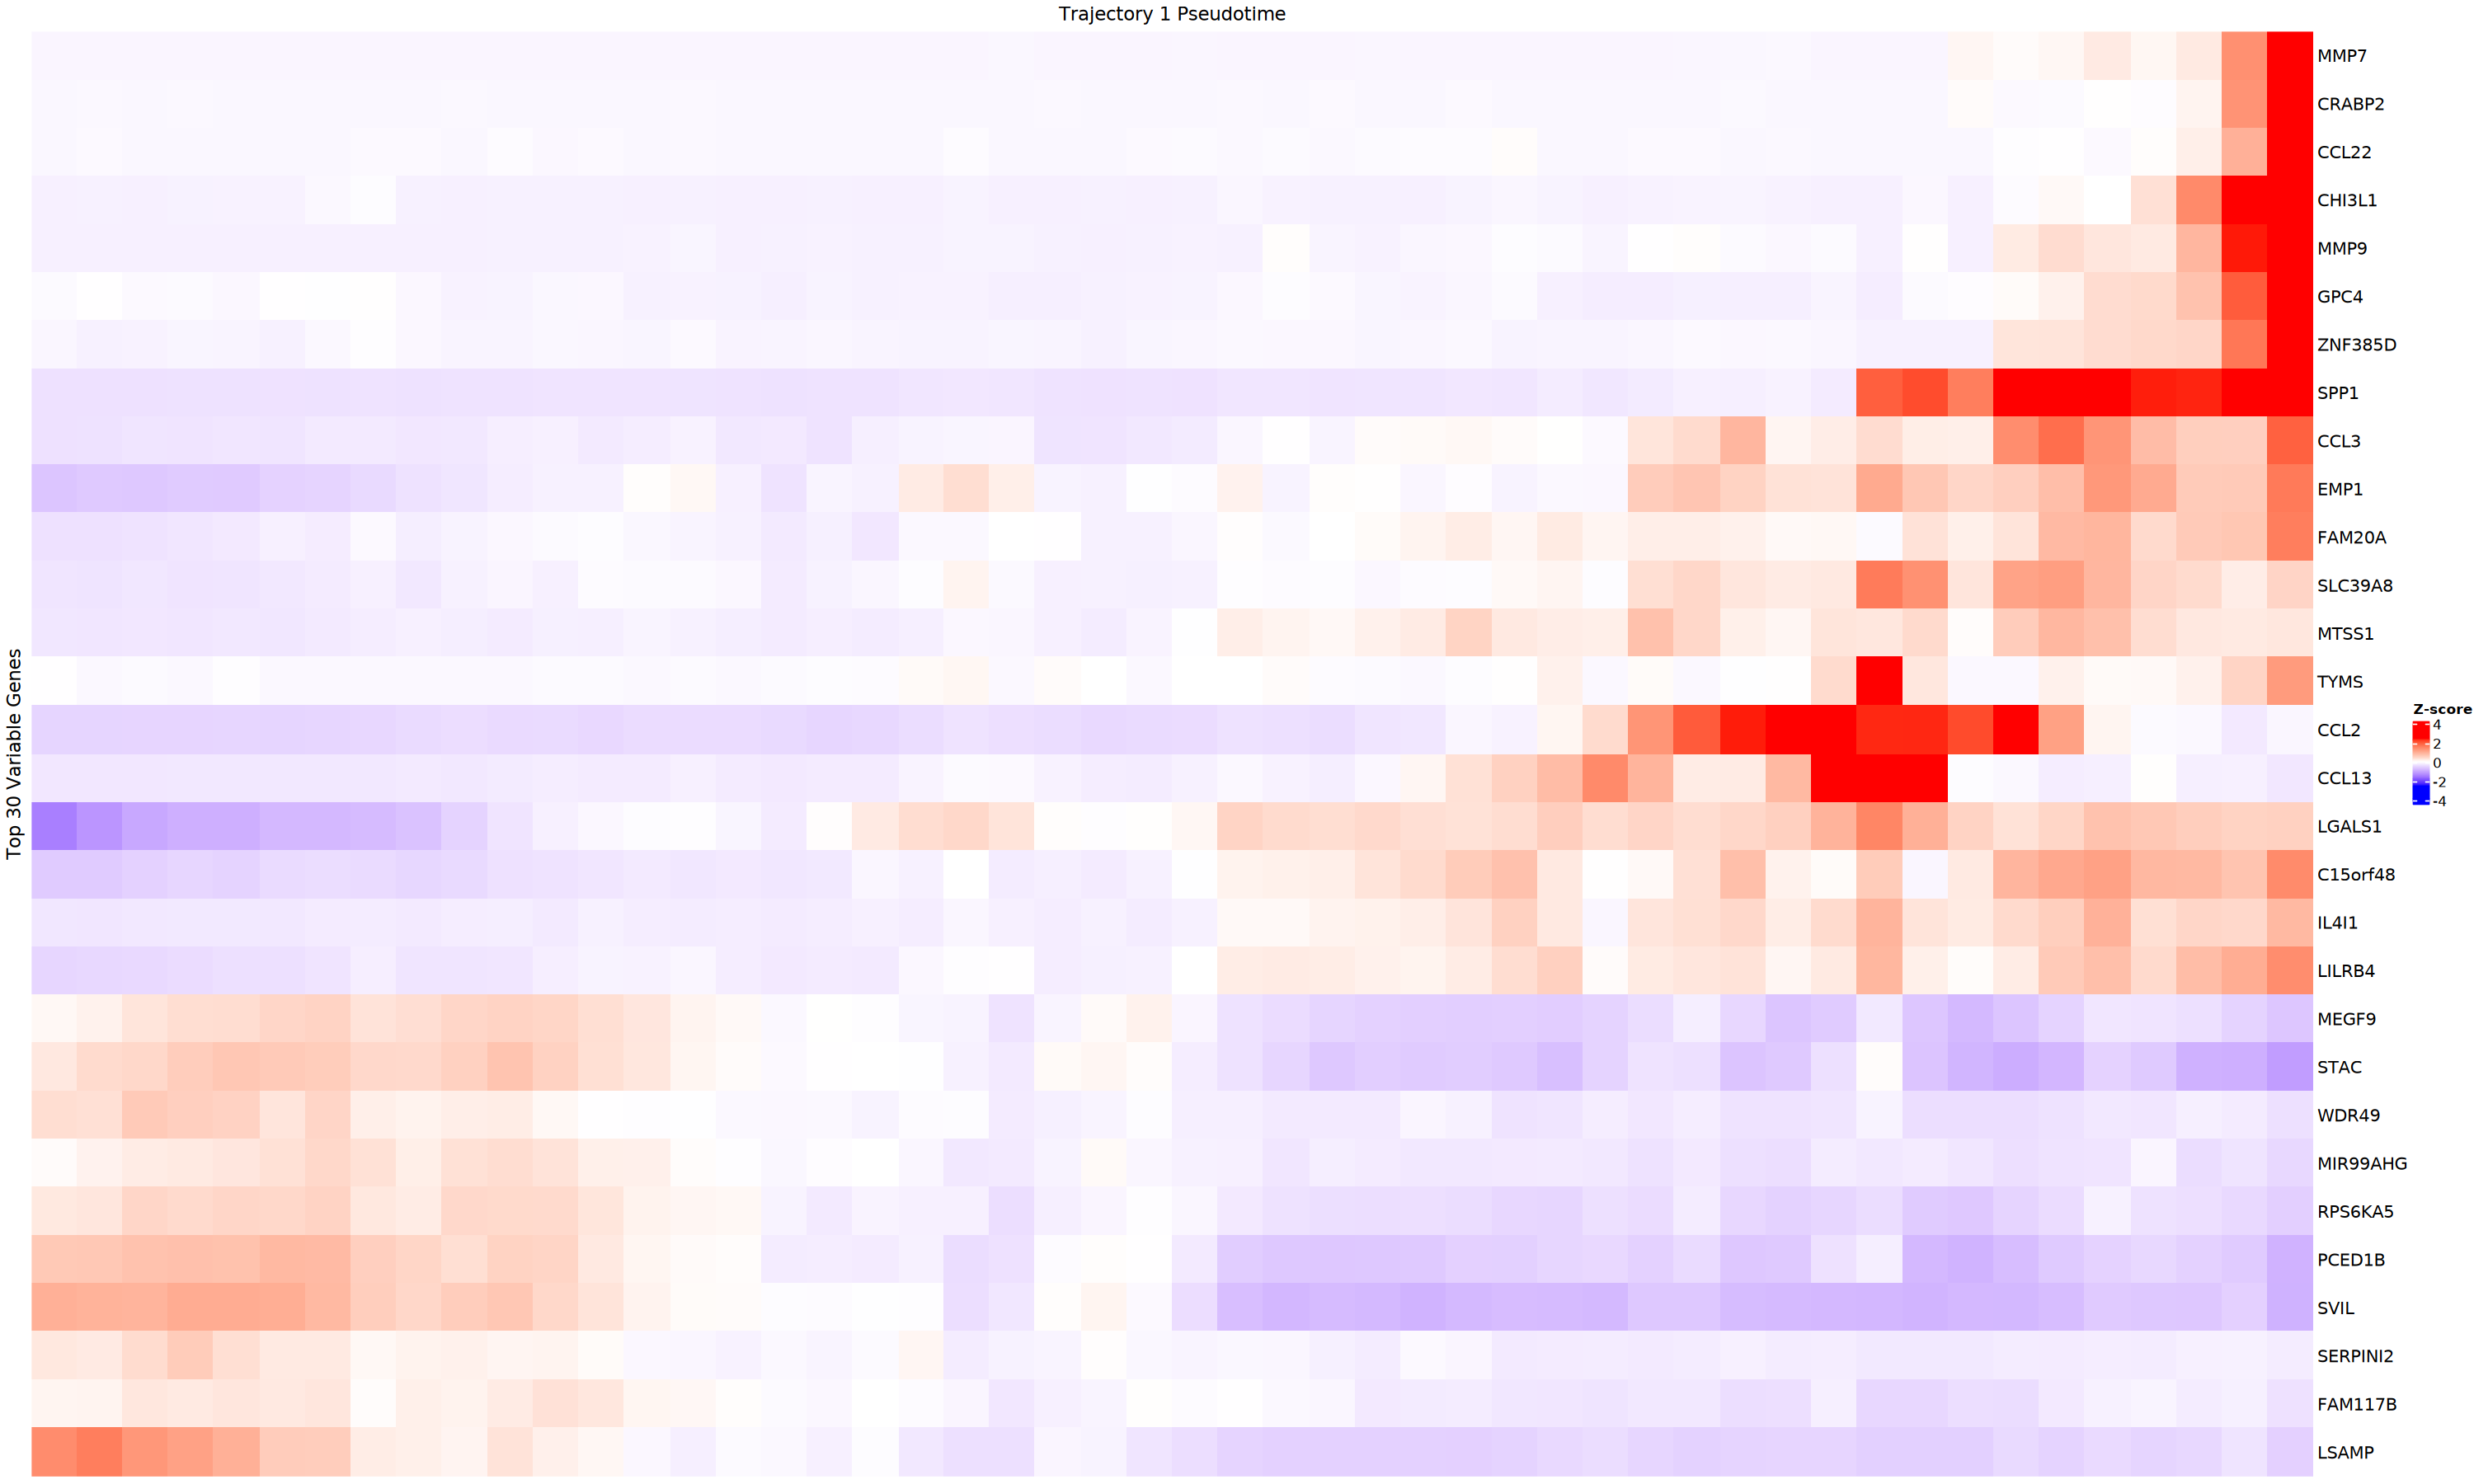

In [12]:
print("Trajectory 2 Heatmap:")
draw(ht1)

## Figure 3c: Cell type proportion analysis of each MLM subcluster (out of all MLMs) in each ILD subtype

In [13]:
# Obtaining proportions via propeller to generate cell type proportion graphs
props <- getTransformedProps(mdm$Cell_Sub_subtype, mdm$Sample, transform="logit")
prop_data <- as.data.frame(props$Proportions)

# Add mapping of disease to sample
sample_disease_map <- unique(mdm@meta.data[, c("Sample", "disease_final")])
disease_lookup <- setNames(as.character(sample_disease_map$disease_final), 
                          as.character(sample_disease_map$Sample))
prop_data$disease_final <- disease_lookup[as.character(prop_data$sample)]

head(prop_data)

Performing logit transformation of proportions



clusters     sample   Freq       disease_final
1 CCL2hi MLM   B1_RZ725 0.06694561 HP           
2 CXCL10hi MLM B1_RZ725 0.66527197 HP           
3 IL1Bhi MLM   B1_RZ725 0.01255230 HP           
4 MLM0         B1_RZ725 0.05020921 HP           
5 MLM1         B1_RZ725 0.17991632 HP           
6 SPP1hi MLM   B1_RZ725 0.02510460 HP

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


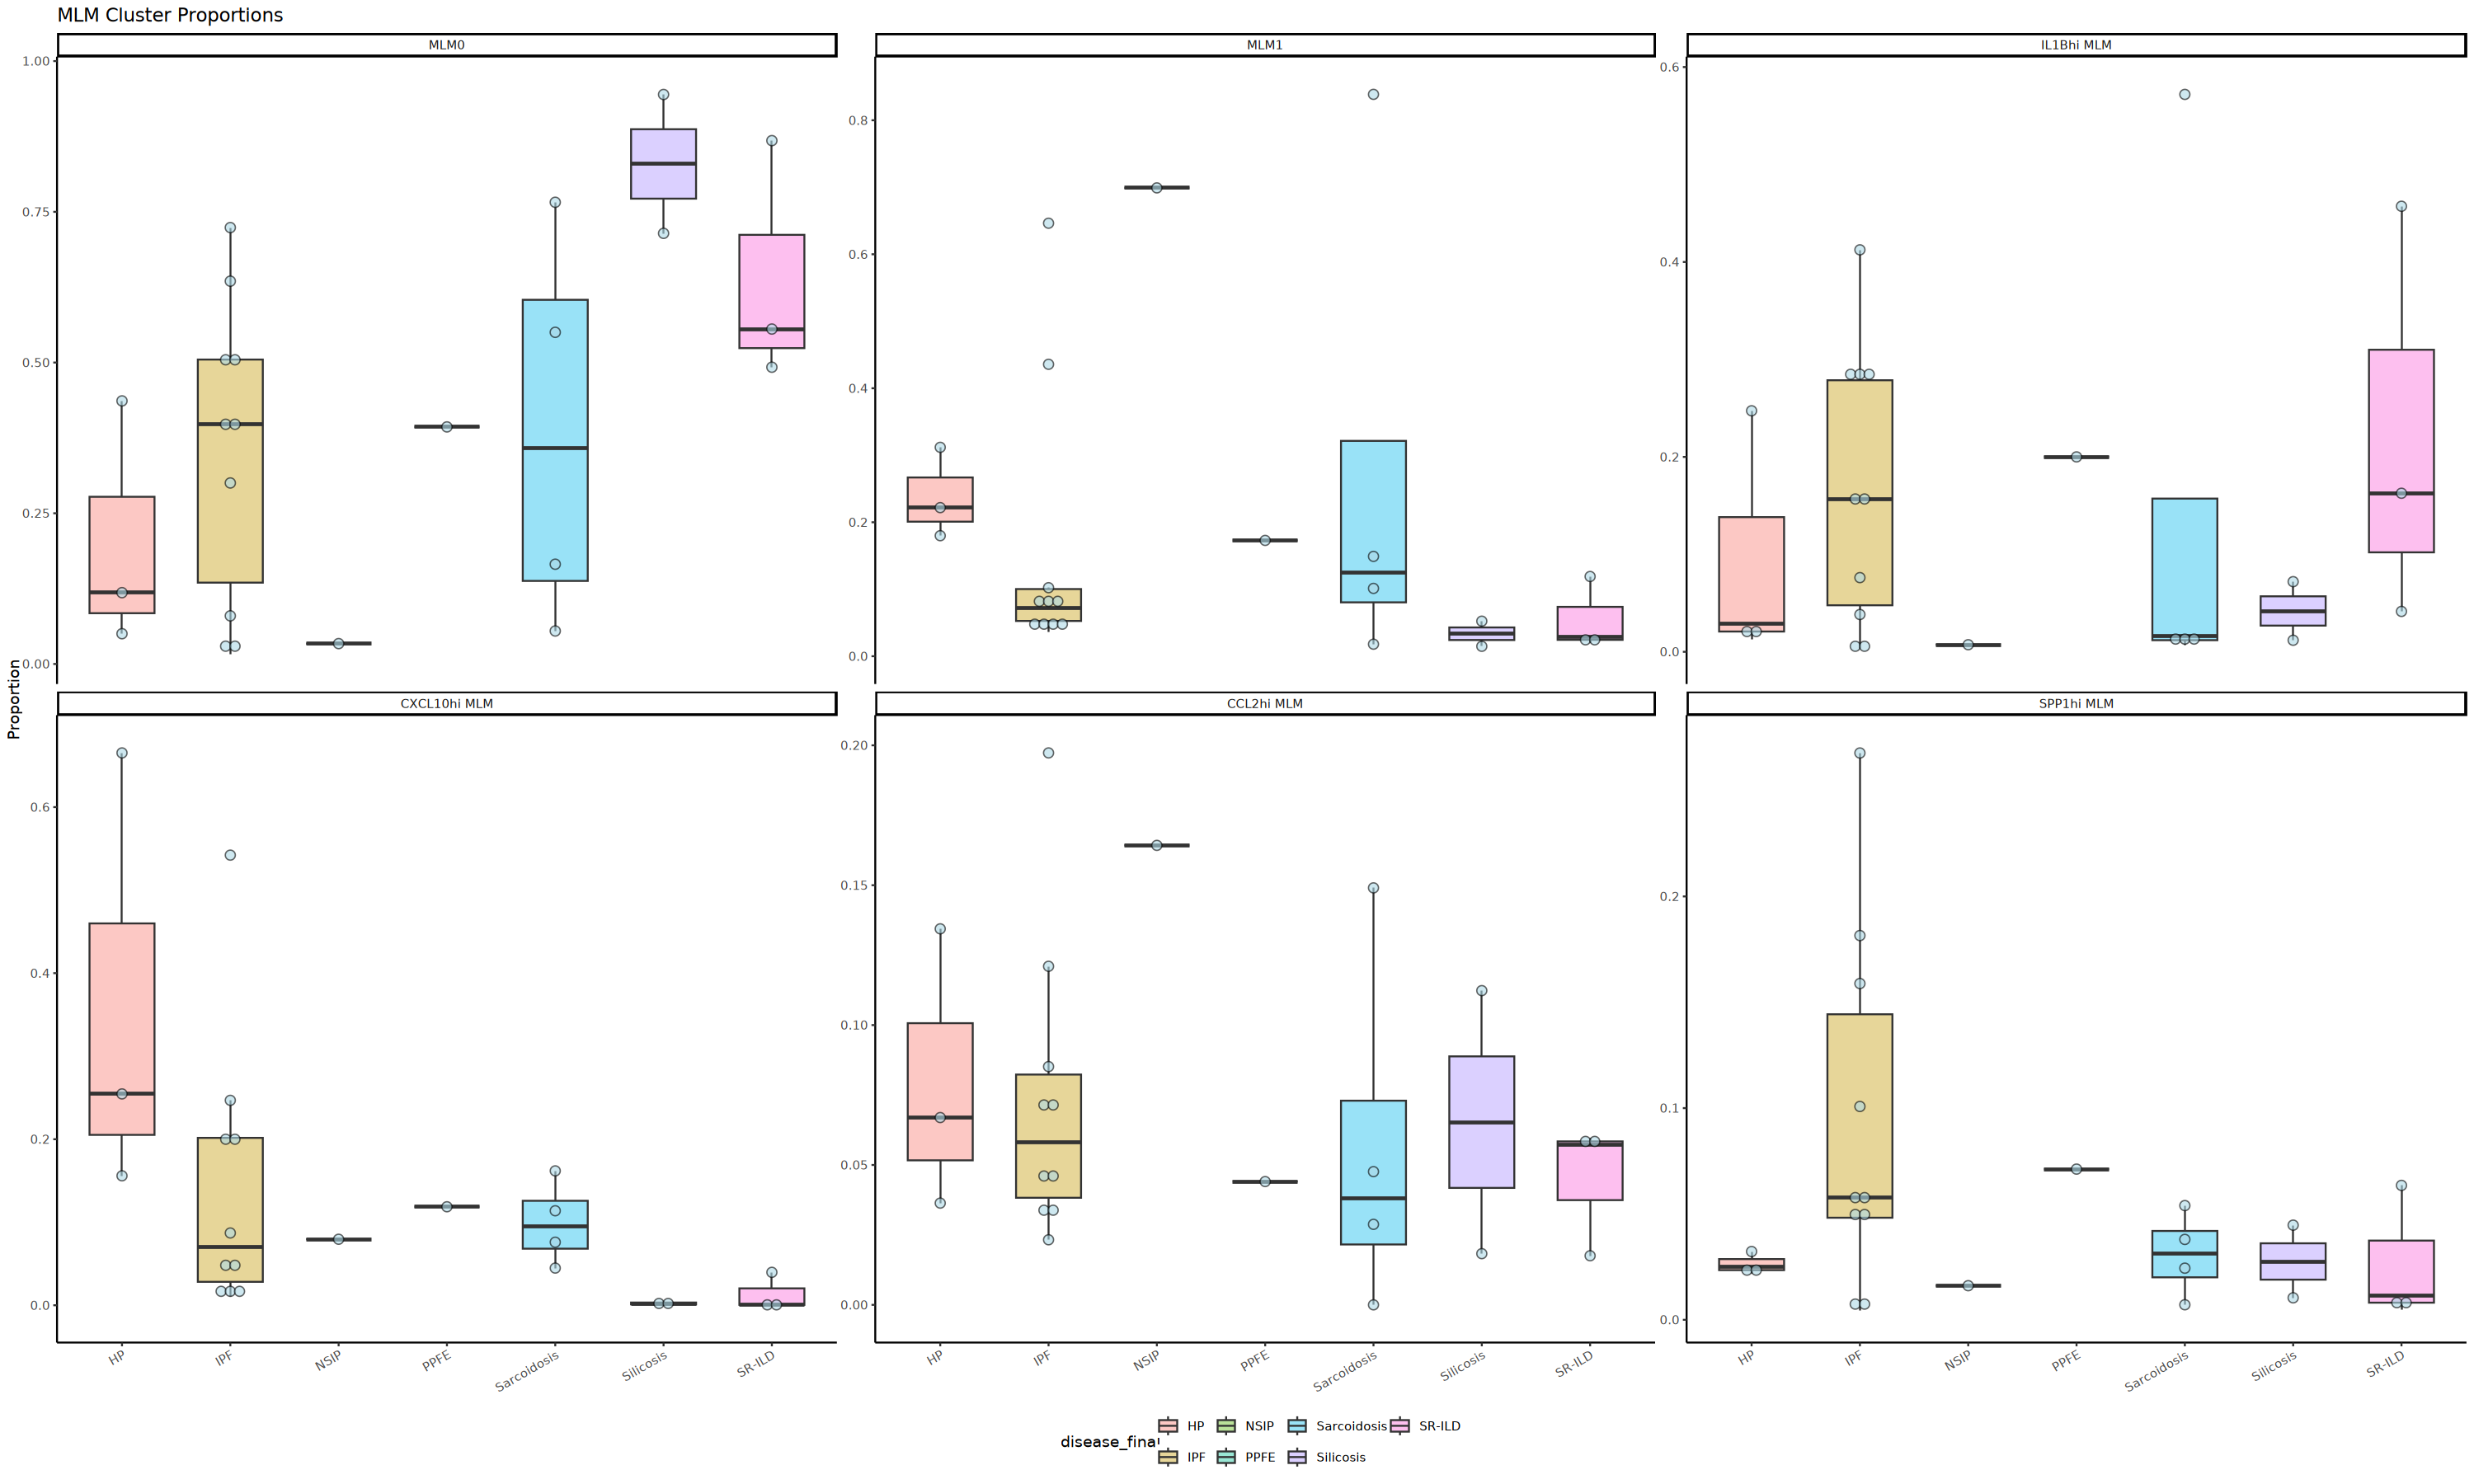

In [15]:
# Order MLM clusters in order
cluster_names <- c("MLM0", "MLM1", "IL1Bhi MLM", "CXCL10hi MLM", "CCL2hi MLM", "SPP1hi MLM")

prop_data <- prop_data %>%
  mutate(clusters = factor(clusters, levels = cluster_names))

# Visualization of MLM cluster proportions by disease
ggplot(prop_data, aes(x = disease_final, y = Freq, fill = disease_final)) +
  geom_boxplot(alpha = 0.4, width = 0.6, outlier.shape = NA) +
  geom_dotplot(binaxis = "y", stackdir = "center", 
               dotsize = 0.5, alpha = 0.6, fill = "lightblue") +
  facet_wrap(~ clusters, scales = "free_y", ncol = 3) +
  theme_classic() +
  theme(
    axis.text.x = element_text(angle = 30, hjust = 1),
    legend.position = "bottom"
  ) +
  labs(
    x = NULL,
    y = "Proportion", 
    title = "MLM Cluster Proportions"
  )

## Figure 3d: Differential expression of selected fibrotic genes in the SPP1hi MLM subcluster of non-IPF and IPF monocyte-like macrophages

Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


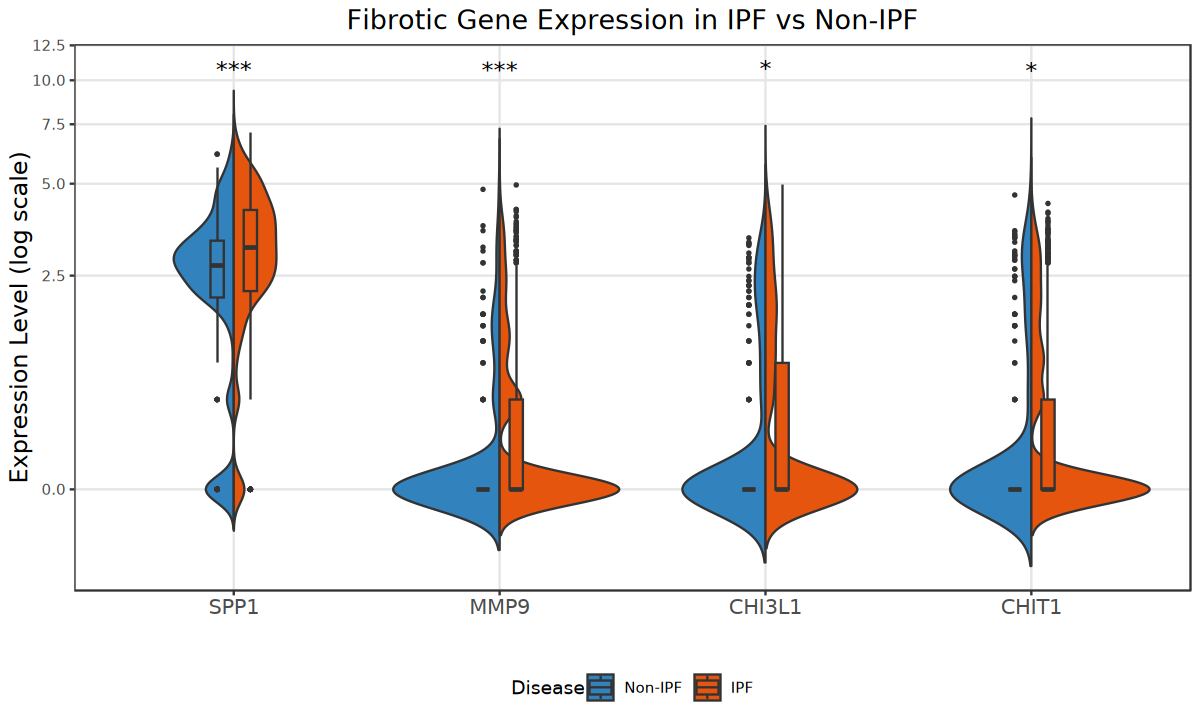

In [3]:
# subset out SPP1hi MLMs only
macs <- subset(bal, Cell_Sub_subtype == "SPP1hi MLM")

# generate split violin plot using GeomSplitViolin
GeomSplitViolin <- ggproto("GeomSplitViolin", GeomViolin, 
                           draw_group = function(self, data, ..., draw_quantiles = NULL) {
  data <- transform(data, xminv = x - violinwidth * (x - xmin), xmaxv = x + violinwidth * (xmax - x))
  grp <- data[1, "group"]
  newdata <- plyr::arrange(transform(data, x = if (grp %% 2 == 1) xminv else xmaxv), if (grp %% 2 == 1) y else -y)
  newdata <- rbind(newdata[1, ], newdata, newdata[nrow(newdata), ], newdata[1, ])
  newdata[c(1, nrow(newdata) - 1, nrow(newdata)), "x"] <- round(newdata[1, "x"])
  if (length(draw_quantiles) > 0 & !scales::zero_range(range(data$y))) {
    stopifnot(all(draw_quantiles >= 0), all(draw_quantiles <=
      1))
    quantiles <- ggplot2:::create_quantile_segment_frame(data, draw_quantiles)
    aesthetics <- data[rep(1, nrow(quantiles)), setdiff(names(data), c("x", "y")), drop = FALSE]
    aesthetics$alpha <- rep(1, nrow(quantiles))
    both <- cbind(quantiles, aesthetics)
    quantile_grob <- GeomPath$draw_panel(both, ...)
    ggplot2:::ggname("geom_split_violin", grid::grobTree(GeomPolygon$draw_panel(newdata, ...), quantile_grob))
  }
  else {
    ggplot2:::ggname("geom_split_violin", GeomPolygon$draw_panel(newdata, ...))
  }
})

geom_split_violin <- function(mapping = NULL, data = NULL, stat = "ydensity", position = "identity", ..., 
                              draw_quantiles = NULL, trim = TRUE, scale = "area", na.rm = FALSE, 
                              show.legend = NA, inherit.aes = TRUE) {
  layer(data = data, mapping = mapping, stat = stat, geom = GeomSplitViolin, 
        position = position, show.legend = show.legend, inherit.aes = inherit.aes, 
        params = list(trim = trim, scale = scale, draw_quantiles = draw_quantiles, na.rm = na.rm, ...))
}

# extract the data for genes of interest in the specified order
genes_of_interest <- c("SPP1", "MMP9", "CHI3L1", "CHIT1")
expression_data <- FetchData(macs, vars = genes_of_interest, slot = "data")

# get the IPF status
ipf_status <- macs@meta.data$IPF
expression_data$IPF <- factor(ipf_status, levels = c("Non-IPF", "IPF"))
expression_data <- expression_data %>% filter(!is.na(IPF))

# reshape to long format
expression_long <- expression_data %>%
  pivot_longer(cols = all_of(genes_of_interest),
               names_to = "Gene",
               values_to = "Expression")

# ensure genes are ordered correctly
expression_long$Gene <- factor(expression_long$Gene, levels = genes_of_interest)

# create group variable
expression_long$group <- as.numeric(interaction(expression_long$Gene, expression_long$IPF, drop = FALSE))

# calculate p-values for each gene
p_values <- data.frame(Gene = character(), p_value = numeric(), sig_symbol = character(), stringsAsFactors = FALSE)

for (gene in genes_of_interest) {
  # Subset data for the current gene
  gene_data <- expression_long %>% filter(Gene == gene)
  
  # Extract expression values for each group
  ipf_expr <- gene_data %>% filter(IPF == "IPF") %>% pull(Expression)
  nonipf_expr <- gene_data %>% filter(IPF == "Non-IPF") %>% pull(Expression)
  
  # Perform Wilcoxon test
  test_result <- wilcox.test(ipf_expr, nonipf_expr, exact = FALSE)
  
  # Get p-value and determine significance symbol
  p_val <- test_result$p.value
  
  if (p_val < 0.001) {
    symbol <- "***"
  } else if (p_val < 0.01) {
    symbol <- "**"
  } else if (p_val < 0.05) {
    symbol <- "*"
  } else {
    symbol <- "ns"
  }
  
  # Add to results dataframe
  p_values <- rbind(p_values, data.frame(
    Gene = gene,
    p_value = p_val,
    sig_symbol = symbol
  ))
}

# add asterisk annotation to plot to indicate p value - place at top of plot above highest gene expression
annotations <- data.frame(
  Gene = factor(p_values$Gene, levels = genes_of_interest),
  p_value = p_values$p_value,
  sig_symbol = p_values$sig_symbol,
  y_pos = numeric(length(p_values$Gene)),
  stringsAsFactors = FALSE
)

# Calculate max expression for each gene
for (i in 1:nrow(annotations)) {
  gene_name <- as.character(annotations$Gene[i])
  max_expr <- max(expression_long$Expression[expression_long$Gene == gene_name], na.rm = TRUE)
  
  if (gene_name == "SPP1") {
    multiplier <- 1.5  
  } else if (gene_name == "MMP9") {
    multiplier <- 2.15  
  } else if (gene_name == "CHI3L1") {
    multiplier <- 2.17  
  } else if (gene_name == "CHIT1") {
    multiplier <- 2.3  
  }
  
  annotations$y_pos[i] <- max_expr * multiplier
}

# Create the plot
p <- ggplot(expression_long, aes(x = Gene, y = Expression, fill = IPF)) + 
  geom_split_violin(trim = FALSE) + 
  geom_boxplot(width = 0.1, position = position_dodge(0.25), outlier.size = 0.5) + 
  geom_text(data = annotations, 
            aes(x = Gene, y = y_pos, label = sig_symbol),
            inherit.aes = FALSE,
            size = 5) + 
  scale_y_continuous(trans = "log1p") + 
  scale_fill_manual(
    values = c("Non-IPF" = "#3182BD", "IPF" = "#E6550D"),
    drop = FALSE
  ) + 
  theme_bw() + 
  theme(
    legend.position = "bottom",
    axis.text.x = element_text(angle = 0, hjust = 0.5, size = 12),
    axis.title = element_text(size = 14),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank(),
    plot.title = element_text(hjust = 0.5, size = 16)
  ) + 
  labs(
    title = "Fibrotic Gene Expression in IPF vs Non-IPF",
    x = "",
    y = "Expression Level (log scale)",
    fill = "Disease"
  )

options(repr.plot.width = 10, repr.plot.height = 6)
print(p)